**SOFTWARE ENGINEERING PROJECT ON DOCUMENT CLASSIFICATION USING HAN MECHANISM** 

**TEXT CLASSIFICATION USING HIERARCHICAL ATTENTION NETWORK**


*FOR DOCUMENT CATEGORIZATION*



>>>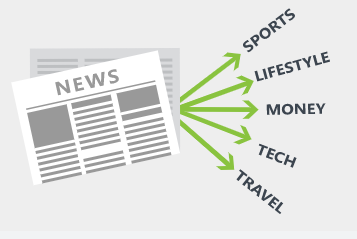





# Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
from bs4 import BeautifulSoup
import re

import os
import sys
from IPython.display import display, HTML
import urllib
import gzip

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import pip
#import theano
import keras
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
#from keras.engine.topology import Layer
from keras.utils import plot_model, np_utils
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# import os
# os.environ["KERAS_BACKEND"] = "theano"
# import keras.backend
# keras.backend.set_image_dim_ordering('th')

In [ ]:
!pip uninstall keras
!pip install keras==2.2.4

import os

os.environ["KERAS_BACKEND"] = "theano"
import keras.backend
keras.backend.set_image_dim_ordering('th')

Found existing installation: keras 2.9.0
Uninstalling keras-2.9.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.9.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 312 kB 5.2 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.2.4 which is incompatible.


AttributeError: ignored

# FUNCTIONS

In [4]:
def cleanString(review,stopWords):
    lemmatizer = WordNetLemmatizer()
    returnString = ""
    sentence_token = tokenize.sent_tokenize(review)
    idx_list = []
    for j in range(len(sentence_token)):
        single_sentence = tokenize.word_tokenize(sentence_token[j])
        sentences_filtered = [(idx,lemmatizer.lemmatize(w.lower())) for idx,w in enumerate(single_sentence) 
                              if w.lower() not in stopWords and w.isalnum()]
        idx_list.append([x[0] for x in sentences_filtered])
        word_list = [x[1] for x in sentences_filtered]
        returnString = returnString + ' '.join(word_list) + ' . '
    
    return returnString, idx_list


def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
    """
    Splits a pandas dataframe into trainingset, validationset and testset in specified ratio.
    All sets are balanced, which means they have the same ratio for each categorie as the full set.
    Input:   dataframe        - Pandas Dataframe, should include a column for data and one for categories
             column_name      - Name of dataframe column which contains the categorical output values
             training_split   - from ]0,1[, default = 0.6validation_split - from ]0,1[, default = 0.2        
             test_split       - from ]0,1[, default = 0.2
                                Sum of all splits need to be 1
    Output:  train            - Pandas DataFrame of trainset
             validation       - Pandas DataFrame of validationset
             test             - Pandas DataFrame of testset
    """
    if training_split + validation_split + test_split != 1.0:
        raise ValueError('Split paramter sum should be 1.0')
        
    total = len(dataframe.index)
 
    train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
    train = train.sample(frac=1)
    temp_df = dataframe.drop(train.index)
    validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
    validation = validation.sample(frac=1)
    test = temp_df.drop(validation.index)
    test = test.sample(frac=1)
    
    print('Total: ', len(dataframe))
    print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
    print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))  
    print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

    return train, validation, test

def wordToSeq(text,word_index,max_sentences,max_words,max_features):
    """
    Converts a string to a numpy matrix where each word is tokenized.
    Arrays are zero-padded to max_sentences and max_words length.
    
    Input:    text           - string of sentences
              word_index     - trained word_index
              max_sentences  - maximum number of sentences allowed per document for HAN
              max_words      - maximum number of words in each sentence for HAN
              max_features   - maximum number of unique words to be tokenized
    Output:   data           - Numpy Matrix of size [max_sentences x max_words]
    """
    sentences = tokenize.sent_tokenize(text)
    data = np.zeros((max_sentences, max_words), dtype='int32')
    for j, sent in enumerate(sentences):
        if j< max_sentences:
            wordTokens = tokenize.word_tokenize(sent.rstrip('.'))
            wordTokens = [w for w in wordTokens]
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_words and word_index[word]<max_features:
                        data[j,k] = word_index[word]
                        k=k+1
                except:
                    pass
    return data

def to_categorical(series,class_dict):
    """
    Converts category labels to vectors,Input:     series     - pandas Series containing numbered category labels
               class_dict - dictionary of integer to category string 
                            e.g. {0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'}
    Output:    Array      - numpy array containing categories converted to lists
                            e.g. 0:'business'      -> [1 0 0 0 0]
                                 1:'entertainment' -> [0 1 0 0 0]
                                 2:'politics'      -> [0 0 1 0 0]
                                 3:'sport'         -> [0 0 0 1 0]
                                 4:'tech'          -> [0 0 0 0 1]
    """
    n_classes = len(class_dict)
    new_dict = {}
    for key,value in class_dict.items():
        cat_list = [0] * n_classes
        cat_list[key] = 1
        new_dict[key] = cat_list
    y_cat = []
    for key,value in series.iteritems():
        y_cat.append(new_dict[value])
    return np.array(y_cat)

# Attention Layer

In [ ]:
!pip install tensorflow==1.14 keras==2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 54 kB/s 
     |████████████████████████████████| 300 kB 48.5 MB/s 
     |████████████████████████████████| 50 kB 5.8 MB/s 
     |████████████████████████████████| 488 kB 62.6 MB/s 
     |████████████████████████████████| 3.1 MB 49.0 MB/s 
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install keras==2.2.0 and tensorflow==1.14.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    tensorflow 1.14.0 depends on keras-preprocessing>=1.0.5
    keras 2.2.0 depends on keras-preprocessing==1.0.1

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for h

In [22]:
#from tensorflow.keras.layers import Layer
from keras import layers
from keras.layers import Layer
class AttentionLayer(Layer):
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
        self.b = K.variable(self.init((self.attention_dim, )),name='b')
        self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)
def compute_mask(self, input, input_mask=None):
        return None

def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        #if self.return_coefficients:
            #return [K.sum(weighted_input, axis=1), ait]
        #else:
            #return K.sum(weighted_input, axis=1)
        if self.return_coefficients:
            return [K.sum(input_shape, axis=1), ait]
        else:
            return K.sum(input_shape, axis=1)

def compute_output_shape(self, input_shape):
  if self.return_coefficients:
     return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
  else:
     return input_shape[0], input_shape[-1]

# LOADING DATASET


***NEWS CLASSIFICATION USING BBC DATASET***

BBC Dataset contains 2225 news articles from the bbc news website from 2004-2005 The dataset was accumulated by D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006
Source: http://mlg.ucd.ie/datasets/bbc.html
Classes are: business, entertainment, politics, sport, tech Directory structure for the dataset shoud be as shown here:

Current directory:

bbc:

...||--business

...||--entertainment

...||--politics

...||--sport

...||--tech


In [ ]:
from google.colab import files
uploaded=files.upload()

In [ ]:
from zipfile import ZipFile
uploaded=files.upload()

Saving bbc[1].classes to bbc[1].classes


In [ ]:
from zipfile import ZipFile
uploaded=files.upload()

Saving bbc.zip to bbc.zip


In [ ]:
from zipfile import ZipFile
file_name = ('/content/bbc.zip')
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')
 #REFRESH PAGE

Done


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [6]:
import os
cwd = os.getcwd()  # Get the current working directory (cwd)
filepath=('/content/drive/MyDrive/Colab Notebooks/bbc')
#filepath = os.path.join(cwd,"bbc")
articles = []
category_num = {}
count = 0
for item in os.listdir(filepath):
    category_num[item] = count
    count += 1
    if os.path.isdir(os.path.join(filepath,item)):
        sub_dir = os.path.join(filepath,item)
        files = [f for f in os.listdir(sub_dir) 
         if os.path.isfile(os.path.join(sub_dir,f))]
        for file in files:
            with open(os.path.join(sub_dir,file)) as text:
                data = text.read()
                paragraphs = data.split('\n', -1)
                title = paragraphs[0] + '. '
                paragraphs[0] = title
                data = ''.join(paragraphs)
                articles.append((data,item))

data_df = pd.DataFrame(data=articles,columns=['Text',"Category"])

In [7]:
data_df

,Text,Category
0,London hope over Chepkemei. London Marathon or...,sport
1,Isinbayeva claims new world best. Pole vaulter...,sport
2,GB quartet get cross country call. Four Britis...,sport
3,Parker misses England clash. Tom Shanklin will...,sport
4,Stam spices up Man Utd encounter. AC Milan def...,sport
...,...,...
835,Consumer concern over RFID tags. Consumers are...,tech
836,Mobile audio enters new dimension. As mobile p...,tech
837,IBM frees 500 software patents. Computer giant...,tech
838,File-swappers ready new network. Legal attacks...,tech


In [8]:
data_df.head()

,Text,Category
0,London hope over Chepkemei. London Marathon or...,sport
1,Isinbayeva claims new world best. Pole vaulter...,sport
2,GB quartet get cross country call. Four Britis...,sport
3,Parker misses England clash. Tom Shanklin will...,sport
4,Stam spices up Man Utd encounter. AC Milan def...,sport


In [9]:
data_df.tail()

,Text,Category
835,Consumer concern over RFID tags. Consumers are...,tech
836,Mobile audio enters new dimension. As mobile p...,tech
837,IBM frees 500 software patents. Computer giant...,tech
838,File-swappers ready new network. Legal attacks...,tech
839,Tough rules for ringtone sellers. Firms that f...,tech


In [10]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(data_df.shape[0]):
    sent = tokenize.sent_tokenize(data_df.loc[i,'Text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/data_df.shape[0]))

Average number of words in each sentence:  25
Average number of sentences in each document:  19


PARAMETERS

In [11]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 100      # vector size of word embedding

DATA PREPROCESSING

In [12]:
import nltk
nltk.download('omw-1.4')
  

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [13]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

,Text,Category,Code
0,london hope chepkemei . london marathon organi...,sport,0
1,isinbayeva claim new world best . pole vaulter...,sport,0
2,gb quartet get cross country call . four briti...,sport,0
3,parker miss england clash . tom shanklin start...,sport,0
4,stam spice man utd encounter . ac milan defend...,sport,0


TOKENIZATION

In [14]:
"""
Using the keras Tokenizer class a word index is built.
The most 'MAX_FEATURES' used words are tokenized to a number.
this dictionary is saved in word_index
"""
texts = []
n = data_cleaned['Text'].shape[0]
for i in range(n):
    s = data_cleaned['Text'].iloc[i]
    s = ' '.join([word.strip(string.punctuation) for word in s.split() if word.strip(string.punctuation) is not ""])
    texts.append(s)
tokenizer = Tokenizer(num_words=MAX_FEATURES,lower=True, oov_token=None)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

GloVe Embedding Matrix

In [17]:
"""
A pre-trained word to vector is used from GloVe by Pennington et. al.
Source: https://nlp.stanford.edu/projects/glove/
The data was trained on wikipedia articles. Each word is described by a 100d vector.
"""

# Load word vectors from pre-trained dataset
embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'),encoding='UTF-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

# Search words in our word index in the pre-trained dataset
# Create an embedding matrix for our bbc dataset
min_wordCount = 0
absent_words = 0
small_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
word_counts = tokenizer.word_counts
for word, i in word_index.items():
    if word_counts[word] > min_wordCount:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
        else:
            absent_words += 1
    else:
        small_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)),
      '% of total words')
print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(word_index)),
      '% of total words')



Found 6118 word vectors.
Total absent words are 10639 which is 71.47 % of total words
Words with 0 or less mentions 0 which is 0.00 % of total words


# SPLITTING OF DATA SET

In [19]:
"""
Split Pandas Dataframe into train, validation and testset.
Convert data to keras conforming form
"""
print(categoryToCode)
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

#Training
paras = []
for i in range(train['Text'].shape[0]):
    sequence = wordToSeq(train['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_train = np.array(paras)
y_train = to_categorical(train['Code'],categoryToCode)

#Validation
paras = []
for i in range(validation['Text'].shape[0]):
    sequence = wordToSeq(validation['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_val = np.array(paras)
y_val = to_categorical(validation['Code'],categoryToCode)

#Test
paras = []
for i in range(test['Text'].shape[0]):
    sequence = wordToSeq(test['Text'].iloc[i],word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)
    paras.append(sequence)
x_test = np.array(paras)
y_test = to_categorical(test['Code'],categoryToCode)

{0: 'sport', 1: 'tech'}
Total:  840
Training:  672 , Percentage:  0.8
Validation:  84 , Percentage:  0.1
Test: 84 , Percentage:  0.1


# ***HAN MODEL***

In [21]:
"""
Create Keras functional model for hierarchical attention network
"""
embedding_layer = Embedding(len(word_index) + 1,EMBED_SIZE,weights=[embedding_matrix], 
                            input_length=MAX_WORD_NUM, trainable=False,name='word_embedding')

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM,), dtype='int32',name='word_input')
word_sequences = embedding_layer(word_input)
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_sequences)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att,word_coeffs = AttentionLayer(EMBED_SIZE,True,name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)

# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM,MAX_WORD_NUM), dtype='int32',name='sent_input')
sent_encoder = TimeDistributed(wordEncoder,name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)




TypeError: ignored

In [ ]:
# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder.summary())
print(model.summary())

plot_model(model, to_file='model.png',show_shapes=True)
plot_model(wordEncoder, to_file='wordEncoder.png',show_shapes=True)

NameError: ignored

# TRAIN DATA

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=50)

print(history.history.keys())
# Plot of accuracy in each epoch
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Plot of loss in each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: ignored

# TEST DATA

In [ ]:
loss, acc = model.evaluate(x_test,y_test)
print("Test set accuracy: ",acc)
print("Test set loss: ", loss)

NameError: ignored

# SAVING THE MODEL

In [ ]:
# Saving the model in a hdf5 file
model.save('HANMODEL.h5')  

# APPLICATION

Trained HAN model is used to classify new BBC news articles, and creates a short summary of the article using sentence attention weights.
Words with most attention are used as new tags 
Database can be created with tagges, summarized news articles

In [ ]:
# Load model from saved hdf5 file
model = load_model('HANMODEL.h5',custom_objects={'AttentionLayer': AttentionLayer})

articleDB = pd.DataFrame(columns = ['Title','Summary','Text','Category','Tags'])

# INPUT TEXT

This scrapes the website and saves the title and text.
Text is then cleaned as described earlier and converted to a sequence of numbers.

In [ ]:
# Input url of interested article
#article_url = 'https://www.bbc.com/news/business-47068401'
#article_url = 'https://www.bbc.com/news/technology-47071334'
#article_url = 'https://www.bbc.com/news/entertainment-arts-39083228'
article_url = 'https://www.bbc.com/news/newsbeat-47069144'
page = requests.get(article_url) 
soup = BeautifulSoup(page.content,'lxml')

# Get title
articlebody = soup.find("div", {"class": "story-body"})
article_title = soup.find("h1",{"class":"story-body__h1"}).text
print(article_title)

# Get news article
story = soup.find("div", {"class": "story-body__inner"}).findAll('p')
article = []
for p in story:
    p_class = p.get('class')
    if p_class:
        no_twite = [x for x in p_class if "twite" not in x]
        no_intro = [x for x in p_class if "story-body__introduction" not in x]
        if no_twite and no_intro:
            article.append(p.text)
    else:
        article.append(p.text)
article = ' '.join(article)
print(article)

# Clean article with pre described rules
article_cleaned,idx_list = cleanString(article,stopWords)
input_array = wordToSeq(article_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

NameError: ignored

# Sentence Attention Model

Model to get attention weights for each sentence

In [ ]:
sent_att_weights = Model(inputs=sent_input,outputs=sent_coeffs)
output_array = sent_att_weights.predict(np.resize(input_array,(1,MAX_SENTENCE_NUM,MAX_WORD_NUM)))

# Get n sentences with most attention in document
n_sentences = 5
sent_index = output_array.flatten().argsort()[-n_sentences:]
sent_index = np.sort(sent_index)
sent_index = sent_index.tolist()

# Create summary using n sentences
sent_list = tokenize.sent_tokenize(article)
summary = [sent_list[i] for i in sent_index]

# Word Attention Model

Model to get attention weights for each word..
A new model is build to get the normally hidden word attention weights.

In [ ]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait

# Summary as input for word attention
summary_cleaned, summary_idx = cleanString(' '.join(summary),stopWords)
word_input_array = wordToSeq(summary_cleaned,word_index,MAX_SENTENCE_NUM,MAX_WORD_NUM,MAX_FEATURES)

# Create model from word input to output of dense layer right before the attention layer
hidden_word_encoding_out = Model(inputs=wordEncoder.input, outputs=wordEncoder.get_layer('word_dense').output)
# Load weights from trained attention layer
word_context = wordEncoder.get_layer('word_attention').get_weights()
# Compute output of dense layer
hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# Compute context vector using output of dense layer
ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [ ]:
# Get n words with most attention in document
n_words = 5

flattenlist = []
words_unpadded = []
for idx,sent in enumerate(tokenize.sent_tokenize(summary_cleaned)):
    if(idx>=MAX_SENTENCE_NUM):
        break
    attword_list = tokenize.word_tokenize(sent.rstrip('.'))
    ait_short = (1000*ait[idx][:len(attword_list)]).tolist()
    words_unpadded.extend(ait_short)
    flattenlist.extend(attword_list)

    
words_unpadded = np.array(words_unpadded)
sorted_wordlist = [flattenlist[i] for i in words_unpadded.argsort()]

mostAtt_words = []
i = 0
for word in reversed(sorted_wordlist):
    if word not in mostAtt_words:
        mostAtt_words.append(word)
        i += 1
    if(i>=n_words):
        break

# Output

In [ ]:
#Category
res = model.predict(np.expand_dims(input_array,axis=0)).flatten()
cat = categoryToCode[np.argmax(res.flatten())]

# Display information
display(HTML('
'
+article_title.rstrip('.')+''))
print(cat,mostAtt_words)

display(HTML('
Summary of article:
'))
display(' '.join(summary))

display(HTML('
Full text:
'))
display(article)

# Article Database

In [ ]:
# Add to database
articleDB.loc[len(articleDB.index)] = [sent_list[0].rstrip('.'),
                                       ''.join(summary),
                                       article,
                                      cat,
                                      mostAtt_words]
display(articleDB)

NameError: ignored

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
#import sklearn.metrics.confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
from google.colab import files
uploaded=files.upload()

KeyboardInterrupt: ignored

In [3]:
news = pd.read_csv('/content/uci-news-aggregator.csv')
news.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1.394470e+12
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1.394470e+12
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1.394470e+12
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1.394470e+12


In [4]:
news['CATEGORY'].unique() # unique category labels

array(['b', 't', 'e', 'm', nan], dtype=object)

In [5]:
news['TITLE'] = news['TITLE'].str.replace('[^\w\s]','').str.lower() # unpunctuate and lower case

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [5]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


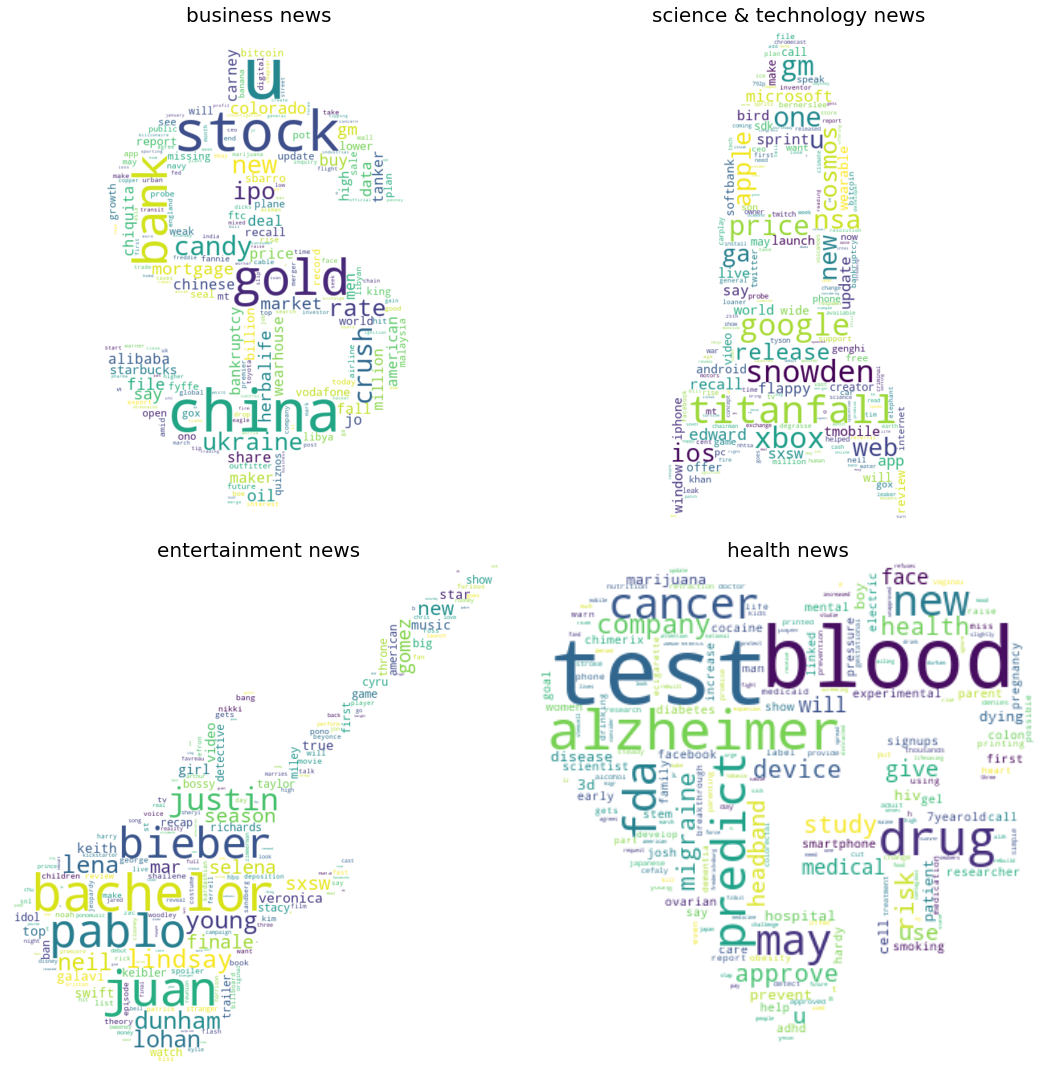

In [9]:
# necessary libraries for wordcloud
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

# create dataframe for each category
b_news = news.loc[news['CATEGORY'] == 'b'] # business
t_news = news.loc[news['CATEGORY'] == 't'] # science and technology
e_news = news.loc[news['CATEGORY'] == 'e'] # entertainment 
m_news = news.loc[news['CATEGORY'] == 'm'] # health

# convert news titles to usable strings for the word clouds
b_title = b_news['TITLE'].to_string()
t_title = t_news['TITLE'].to_string()
e_title = e_news['TITLE'].to_string()
m_title = m_news['TITLE'].to_string()

# import images and make them usable by word cloud
b_image = np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/business.jpg'))
t_image = np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/scitech.jpg'))
e_image = np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/entertainment.jpg'))
m_image = np.array(Image.open('/content/gdrive/MyDrive/Colab Notebooks/health.jpg'))


fig = plt.figure(figsize=(15,15))

# setting stop-words, so words like "the" and "it" are ignored
stopwords = set(STOPWORDS)

# business news cloud
ax1 = fig.add_subplot(221)
b_wordcloud = WordCloud(background_color='white', mask=b_image, collocations=False, stopwords=stopwords).generate(b_title)
ax1.imshow(b_wordcloud, interpolation='bilinear')
ax1.set_title('business news', size=20)
ax1.axis('off')

# science and technology news cloud
ax2 = fig.add_subplot(222)
t_wordcloud = WordCloud(background_color='white', mask=t_image, collocations=False, stopwords=stopwords).generate(t_title)
ax2.imshow(t_wordcloud, interpolation='bilinear')
ax2.set_title('science & technology news', size=20)
ax2.axis('off')

# entertainment news cloud
ax3 = fig.add_subplot(223)
e_wordcloud = WordCloud(background_color='white', mask=e_image, collocations=False, stopwords=stopwords).generate(e_title)
ax3.imshow(e_wordcloud, interpolation='bilinear')
ax3.set_title('entertainment news', size=20)
ax3.axis('off')

# health news cloud
ax4 = fig.add_subplot(224)
m_wordcloud = WordCloud(background_color='white', mask=m_image, collocations=False, stopwords=stopwords).generate(m_title)
ax4.imshow(m_wordcloud, interpolation='bilinear')
ax4.set_title('health news', size=20)
ax4.axis('off')

fig.tight_layout()

Some of the most common words appearing in news headlines (at laest in 2014) for each of the four categories have been:

Business: "stock", "US", "China"
Entertainment: "star", "Kardashian", "Bieber"
Science & Technology: "Facebook", "Google", "new"
Health: "study", "Ebola", "cancer"

This is reassuring. When we do use a function to return the categories of various headlines, the categories returned will make sense

In [10]:
vectorizer = CountVectorizer(stop_words='english') # setting stop-words, so words like "the" and "it" are ignored
X = vectorizer.fit_transform(news['TITLE']) # convert TITLE samples to vectors
y = news['CATEGORY'] # label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 30% split

In [15]:
# model (best params established through gridsearch in notebook)
sgd = SGDClassifier(n_jobs=-1, max_iter=10, alpha=1e-05, loss='hinge', random_state=1234)
sgd.fit(X_train, y_train)

# custom function that inputs a news title, and outputs one of 4 specified categories
def title_to_category(title):
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter = sgd.predict(vectorizer.transform([title]))
    return categories[pridicter[0]]

# testing a headline from The Onion
print(title_to_category("Johnson & Johnson introduces 'nothing but tears shampoo' to 'toughen up' infants."))
# link to article: http://www.theonion.com/article/johnson-johnson-introduces-nothing-but-tears-shamp-2506

# output: health

entertainment


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [13]:
sgd = SGDClassifier(n_jobs=-1, max_iter=10, random_state=1234)

# hyperparameters for tuning
sgd_grid = [{'loss': ['hinge', 'log', 'squared_hinge'],
             'alpha': [0.0001, 0.0001, 0.00001]}]

# grid search with cross validation
sgd_search = GridSearchCV(estimator=sgd, param_grid=sgd_grid, cv=5, refit=True)
sgd_search.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_mo

GridSearchCV(cv=5,
             estimator=SGDClassifier(max_iter=10, n_jobs=-1, random_state=1234),
             param_grid=[{'alpha': [0.0001, 0.0001, 1e-05],
                          'loss': ['hinge', 'log', 'squared_hinge']}])

In [16]:
sgd_search.best_params_

{'alpha': 0.0001, 'loss': 'log'}

In [19]:
sgd.score(X_test, y_test)

TypeError: ignored

In [21]:
#sgd_search.best_estimator_.score(X_test, y_test)
sgd_search.score(X_test, y_test)

TypeError: ignored

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, sgd_search.best_estimator_.predict(X_test), labels = ['b','e','m','t']).grid(False)

TypeError: ignored

In [22]:
# title-category function
def title_to_category(title):
    categories = {'b' : 'business', 
                  't' : 'science and technology', 
                  'e' : 'entertainment', 
                  'm' : 'health'}
    pridicter = sgd_search.best_estimator_.predict(vectorizer.transform([title]))
    return categories[pridicter[0]]

In [23]:
# sample predictions using our sgd classifier on 2017 BBC headlines
print('news title', '                                 ', 'category', '\n' 
      'Bank of England staff to go on strike', '      ', title_to_category('Bank of England staff to go on strike'), '\n'
      'Trump stance could damage Earth - Hawking', '  ', title_to_category('Trump stance could damage Earth - Hawking'), '\n'
      'Olivia de Havilland sues over TV show', '      ', title_to_category('Olivia de Havilland sues over TV show')
     )

news title                                   category 
Bank of England staff to go on strike        business 
Trump stance could damage Earth - Hawking    science and technology 
Olivia de Havilland sues over TV show        entertainment


In [24]:
# testing a headline from The Onion
title_to_category("Johnson & Johnson introduces 'nothing but tears shampoo' to 'toughen up' infants.")
# link to article: http://www.theonion.com/article/johnson-johnson-introduces-nothing-but-tears-shamp-2506

'entertainment'

In [25]:
# another one from The Onion
title_to_category("Archaeological Dig Uncovers Ancient Race Of Skeleton People.")
# link to article: http://www.theonion.com/article/archaeological-dig-uncovers-ancient-race-of-skelet-932
# quote from article: "And though we know little of their language and means of communication, it is likely that they said 'boogedy-boogedy' a lot.

'entertainment'

In [34]:
from google.colab import files
uploaded=files.upload()

Saving test3.txt to test3.txt


In [26]:
# another test case
title_to_category('newstest (1).txt')

'business'

**TEST CASE I**


In [45]:
from google.colab import files
uploaded=files.upload()


Saving newstest1.txt to newstest1.txt


In [47]:
example1 = "newstest1.txt"
file1 = open(example1, "r")
FileContent = file1.read()
FileContent
title_to_category(FileContent)
print('NEWS HEADLINE','                                 ','CATEGORY','\n',FileContent,'      ', title_to_category(FileContent))

NEWS HEADLINE                                   CATEGORY 
 Investor's Alert - Cannabis Science Inc(OTCMKTS:CBIS), HEMP, INC  ...
        health


**TEST CASE II**

In [33]:
example1 = "test2.txt.txt"
file1 = open(example1, "r")
FileContent = file1.read()
FileContent
title_to_category(FileContent)
print('news title', '                                 ', 'category','\n',FileContent, '      ', title_to_category(FileContent))

news title                                   category 
 McDonald's February same-restaurant sales fall 0.3%
        business


**TEST CASE III**

In [38]:
example1 = "test3.txt"
file1 = open(example1, "r")
FileContent = file1.read()
FileContent
title_to_category(FileContent)
print('NEWS TITLE','                              ','CATEGORY','\n',FileContent,'------>      ',title_to_category(FileContent))

NEWS TITLE                                CATEGORY 
 Taylor Swift Tops Music's Top 40 Money Makers 2014 List â€” How Much Did She  ...
 ------>       entertainment


In [ ]:
example1 = "/content/example1.txt"
with open(, "r") as file1:
    FileContent = file1.read()
    print(FileContent)

In [ ]:
example1 = "test3.txt"
with open(example1, "r") as file1:
    FileContent = file1.read()
    print(FileContent)